## Preprocessing for BERT

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch

In [45]:
def get_data(path, augmented = False):
    df = pd.read_csv(path)
    df.dropna(subset=['reviewContent', 'label'], inplace=True)
    max_len = df['reviewContent'].str.len().max()
    print("Maximum length of a review in dataset:", max_len)
    if augmented:
        return df
    df1 = df[df.label == 1]
    df2 = df[df.label == 0].sample(n=df1.shape[0], random_state=1)
    new_df = pd.concat([df1, df2], ignore_index=True)

    data = new_df.sample(frac=1, random_state=2)
    return data

In [46]:
# Load and prepare the dataset
# df = pd.read_csv('preReviewsCSV.csv')

In [47]:
# df.dropna(subset=['reviewContent', 'label'], inplace=True)
# df1 = df[df.label == 1]
# df2 = df[df.label == 0].sample(n=df1.shape[0], random_state=1)
# new_df = pd.concat([df1, df2], ignore_index=True)

In [48]:
# max_len = new_df['reviewContent'].str.len().max()
# print("Maximum length of a review in dataset:", max_len)

In [11]:
new_df = get_data('augmentedReviewsCSV.csv', augmented=True)

Maximum length of a review in dataset: 3950


In [12]:
df_bert = pd.DataFrame({
    'id':range(len(new_df)),
    'label':new_df['label'],
    'alpha':['a']*new_df.shape[0],
    'text': new_df['reviewContent']
})

df_bert.head()

,id,label,alpha,text
0,0,1,a,torn mavin rate placeso ill give dinner party ...
1,1,1,a,good food �nice present �excel servic � come h...
2,2,1,a,doug sausag jedi mani place wait get long pla...
3,3,1,a,im pig sleep with place place never buy someth...
4,4,0,a,eschew hourlong wait hell kitchen companion de...


In [13]:
train_df_bert = df_bert.sample(frac=0.8, random_state=123)
val_df_bert = df_bert.drop(train_df_bert.index)

train_df_bert.shape, val_df_bert.shape

((74794, 4), (18699, 4))

In [14]:
train_df_bert.to_csv('BERT/bert_data/train.tsv', sep='\t', index=False, header=False)
val_df_bert.to_csv('BERT/bert_data/dev.tsv', sep='\t', index=False, header=False)

### Done.... Now converting Data into Features

In [15]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam

from multiprocessing import Pool, cpu_count
from tools import *
import convert_examples_to_features

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
DATA_DIR = 'BERT/bert_data/'
TASK_NAME = 'yelp'

OUTPUT_DIR = f'BERT/bert_outputs/{TASK_NAME}/'

REPORTS_DIR = f'BERT/bert_reports/{TASK_NAME}/'
CACHE_DIR = 'BERT/cache/'

MAX_SEQ_LENGTH = 512

TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 64
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

BERT_MODEL = 'bert-base-uncased'


In [17]:
output_mode = OUTPUT_MODE

cache_dir = CACHE_DIR

In [18]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [19]:
if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
    raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

ValueError: Output directory (BERT/bert_outputs/yelp/) already exists and is not empty.

In [20]:
from __future__ import absolute_import, division, print_function

import csv
import os
import sys
import logging

logger = logging.getLogger()
csv.field_size_limit(2147483647) # Increase CSV reader's field limit incase we have long text.


class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines

class BinaryClassificationProcessor(DataProcessor):
    """Processor for binary classification dataset."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [21]:
processor = BinaryClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)

In [22]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)

In [23]:
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/gaurav/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [25]:
label_map = {label: i for i, label in enumerate(label_list)}
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, output_mode) for example in train_examples]

In [21]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        train_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

Preparing to convert 74794 examples..
Spawning 23 processes..


/tmp/ipykernel_401384/24497431.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  train_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, train_examples_for_processing), total=train_examples_len))


  0%|          | 0/74794 [00:00<?, ?it/s]

In [22]:
with open(DATA_DIR + "train_features.pkl", "wb") as f:
    pickle.dump(train_features, f)

In [26]:
with open(DATA_DIR + "train_features.pkl", 'rb') as file:
    train_features = pickle.load(file)

In [24]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at BERT/cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file BERT/cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmphzcolrec
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:pytorch_pretrained_bert.modeling:Weights of BertForSequenceClassification not initialized from pretrained m

In [25]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP_PROPORTION,
                     t_total=num_train_optimization_steps)

In [27]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [28]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", train_examples_len)
logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
logger.info("  Num steps = %d", num_train_optimization_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)

if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.float)

INFO:root:***** Running training *****
INFO:root:  Num examples = 74794
INFO:root:  Batch size = 16
INFO:root:  Num steps = 4674


In [29]:
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

In [30]:
model.train()
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        logits = model(input_ids, segment_ids, input_mask, labels=None)

        if OUTPUT_MODE == "classification":
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif OUTPUT_MODE == "regression":
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), label_ids.view(-1))

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        print("\r%f" % loss, end='')
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_401384/4038026767.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):


Iteration:   0%|          | 0/4675 [00:00<?, ?it/s]

0.842338

/home/gaurav/Documents/ASU/SWM Project/env/lib/python3.8/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


0.320175

Epoch: 100%|██████████| 1/1 [29:52<00:00, 1792.90s/it]

0.099377

In [31]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(OUTPUT_DIR)

'BERT/bert_outputs/yelp/vocab.txt'

### Evaluating Model

In [27]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

In [28]:
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "task": task_name,
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "accuracy":(tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

In [29]:
tokenizer = BertTokenizer.from_pretrained(OUTPUT_DIR + 'vocab.txt', do_lower_case=False)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file BERT/bert_outputs/yelp/vocab.txt


In [30]:
processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

In [31]:
label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in eval_examples]

In [32]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {eval_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

Preparing to convert 18699 examples..
Spawning 23 processes..


/tmp/ipykernel_425921/3869957562.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))


  0%|          | 0/18699 [00:00<?, ?it/s]

In [33]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)

In [34]:
if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)

In [35]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

# Run prediction for test data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [36]:
# load the pretrained bert model
model = BertForSequenceClassification.from_pretrained(OUTPUT_DIR, cache_dir=CACHE_DIR, num_labels=len(label_list))

INFO:pytorch_pretrained_bert.modeling:loading archive file BERT/bert_outputs/yelp/
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [37]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [38]:
import numpy as np

In [39]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    if OUTPUT_MODE == "classification":
        loss_fct = CrossEntropyLoss()
        tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    elif OUTPUT_MODE == "regression":
        loss_fct = MSELoss()
        tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
if OUTPUT_MODE == "classification":
    preds = np.argmax(preds, axis=1)
elif OUTPUT_MODE == "regression":
    preds = np.squeeze(preds)
result = compute_metrics(TASK_NAME, all_label_ids.numpy(), preds)

result['eval_loss'] = eval_loss

output_eval_file = os.path.join(REPORTS_DIR, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

/tmp/ipykernel_425921/3379476282.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/293 [00:00<?, ?it/s]

INFO:root:***** Eval results *****
INFO:root:  task = yelp
INFO:root:  mcc = 0.8469543774041167
INFO:root:  tp = 8372
INFO:root:  tn = 8872
INFO:root:  fp = 371
INFO:root:  fn = 1084
INFO:root:  accuracy = 0.9221883523183058
INFO:root:  eval_loss = 0.17585761152182422


In [40]:
from sklearn.metrics import classification_report
from ml_things import plot_dict, plot_confusion_matrix

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      9243
           1       0.96      0.89      0.92      9456

    accuracy                           0.92     18699
   macro avg       0.92      0.92      0.92     18699
weighted avg       0.92      0.92      0.92     18699

Normalized confusion matrix


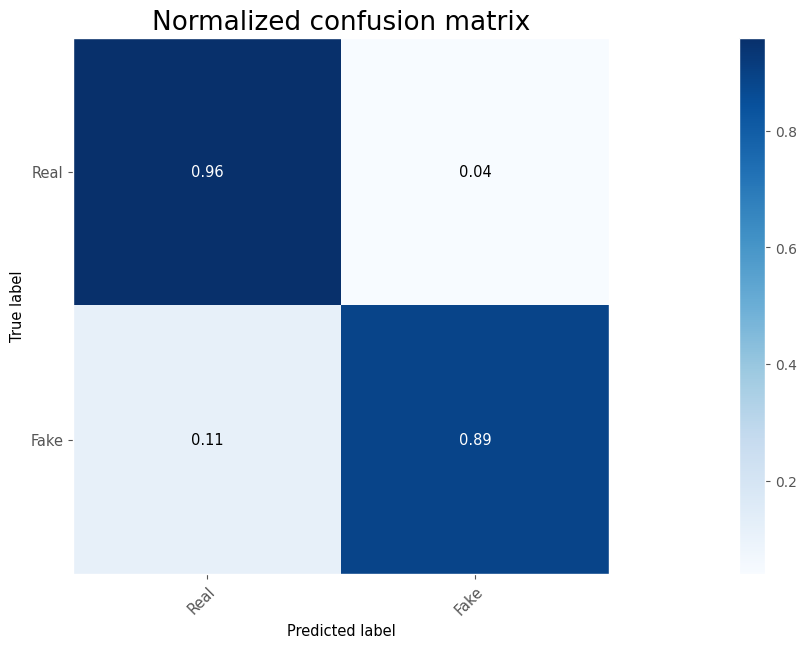

array([[0.95986152, 0.04013848],
       [0.11463621, 0.88536379]])

In [43]:
evaluation_report = classification_report(all_label_ids.numpy(), preds, labels=[0, 1])
print(evaluation_report)
plot_confusion_matrix(y_true=all_label_ids.numpy(), y_pred=preds, 
                      classes=['Real', 'Fake'], normalize=True, 
                      magnify=0.1,
                      )
